### Objective:  
you’re building an AI to detect if a headline is fake news. the dataset is just a list of headlines
(true or fake).  
what basic model would you use?  
bonus: what would you do if you had zero data to start?

In [60]:
# importing necessary libraries

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# filter warning
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [61]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

Preprocessing

• Lowercasing  
• special character removal using re  
• Stopword removal    
• lemmatization

In [62]:
def preprocess_text(text):
    """Clean and preprocess text"""
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Clean text
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Only keep letters and spaces
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(tokens)


In [63]:
# Load data
df = pd.read_csv('train.csv', on_bad_lines='skip',engine='python')

In [64]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


### i am using sample data which i got from kaggle , i am taking only taking  title column and the label column

In [65]:
df = df[['title', 'label']]
df.dropna(inplace=True)

In [66]:
df.shape

(20242, 2)

In [67]:
# Converting label column to numeric
df['label'] = pd.to_numeric(df['label'], errors='coerce')

# Dropping rows where label is NOT 0 or 1
df.drop(df[~df['label'].isin([0, 1])].index, inplace=True)

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20240 entries, 0 to 20821
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   title   20240 non-null  object 
 1   label   20240 non-null  float64
dtypes: float64(1), object(1)
memory usage: 474.4+ KB


In [69]:
# Apply preprocessing
df['title'] = df['title'].apply(preprocess_text)

In [70]:
df.head()

,title,label
0,house dem aide didnt even see comeys letter ja...,1.0
1,flynn hillary clinton big woman campus breitbart,0.0
2,truth might get fired,1.0
3,civilian killed single u airstrike identified,1.0
4,iranian woman jailed fictional unpublished sto...,1.0


In [71]:
# Parameters
MAX_VOCAB = 5000
MAX_LEN = 100

# Initialize tokenizer
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(df['title'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['title'])

# Pad sequences
padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

In [72]:
X = padded_sequences
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

we are using bidirectional lstm because Bidirectional LSTM reads the same sequence from both directions

In [73]:
model = Sequential()
model.add(Embedding(input_dim=MAX_VOCAB, output_dim=64, input_length=MAX_LEN))
model.add(Bidirectional(LSTM(100)))  # ← just use this directly
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [74]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 80s 146ms/step - accuracy: 0.8376 - loss: 0.3534 - val_accuracy: 0.9284 - val_loss: 0.1696
Epoch 2/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 85s 153ms/step - accuracy: 0.9604 - loss: 0.1095 - val_accuracy: 0.9333 - val_loss: 0.1755
Epoch 3/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 77s 143ms/step - accuracy: 0.9722 - loss: 0.0857 - val_accuracy: 0.9313 - val_loss: 0.1934
Epoch 4/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 82s 142ms/step - accuracy: 0.9823 - loss: 0.0540 - val_accuracy: 0.9269 - val_loss: 0.2213
Epoch 5/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 81s 141ms/step - accuracy: 0.9901 - loss: 0.0377 - val_accuracy: 0.9266 - val_loss: 0.2491


In [75]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


127/127 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9236 - loss: 0.2538
Test Accuracy: 0.9266


In [76]:
# Get predicted probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to binary predictions
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step


In [77]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[1935  171]
 [ 126 1816]]


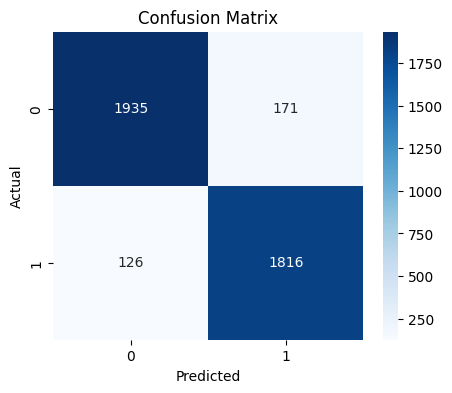

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [79]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93      2106
         1.0       0.91      0.94      0.92      1942

    accuracy                           0.93      4048
   macro avg       0.93      0.93      0.93      4048
weighted avg       0.93      0.93      0.93      4048



bonus: what would you do if you had zero data to start?




In [80]:
from transformers import pipeline

classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
classifier("Aliens invaded Mars yesterday!", candidate_labels=["real", "fake"])


Device set to use cpu


{'sequence': 'Aliens invaded Mars yesterday!',
 'labels': ['real', 'fake'],
 'scores': [0.7663162350654602, 0.2336837202310562]}

In [ ]:
headlines = [
    "NASA confirms water on the moon",
    "President announces free tacos for everyone",
    "Doctors find cure for aging",
    "humans can live without oxygen",
    "Penguins elected as new members of the United Nations Security Council"
]

for h in headlines:
    print(classifier(h, candidate_labels=["real","fake"]))

In [82]:
# based on the result Zero-shot is a cool demo, but not good enough for serious fake news detection.